In [16]:
import importlib
import moc_cart_threaded as MOC
import sn as SN

# import moc_cart as MOC
import shapely

import matplotlib.pyplot as plt

In [17]:
from plot_scalar_flux import *

In [18]:
materials = {
    "reflector": MOC.Material(2.0, 1.80, 0.0, "reflector", "blue"),
    "scatterer": MOC.Material(2.0, 1.99, 0.0, "scatterer", "red"),
    "absorber": MOC.Material(10.0, 2.0, 0.0, "absorber", "green"),
    "air": MOC.Material(0.1, 0.006, 0.0, "air", (0.9, 0.97, 1.0, 0.3)),
    "air2": MOC.Material(0.1, 0.09, 0.0, "air", (0.9, 0.97, 1.0, 0.3)),
    "isotropic": MOC.Material(0.1, 0, 1, "isotropic", "purple"),
    "detector": MOC.Material(1.0, 0, 0, "detector", "yellow"),
    "vacuum": MOC.Material(0.0, 0.0, 0.0, "vacuum", "black"),
}


def sn_material(material_name):
    material = materials[material_name]
    return SN.Material(material.sigma_t, material.sigma_s, material.volumetric_source)

In [19]:
total_dx = 5


def make_blocks(x0, y0, dx=0.1, dy=0.1, total_dx=total_dx, total_dy=total_dx, material=materials["reflector"]):
    """Create a grid of blocks in the x-y plane."""

    if type(material) is str:
        material = materials[material]

    number_blocks_x = int(total_dx / dx)
    assert number_blocks_x == total_dx / dx, "total_dx must be a multiple of dx"
    
    number_blocks_y = int(total_dy / dy)
    assert number_blocks_y == total_dy / dy, "total_dy must be a multiple of dy"

    cells = {}
    for i_block in range(number_blocks_x):
        for j_block in range(number_blocks_y):
            x = x0 + i_block * dx
            y = y0 + j_block * dy
            cell = shapely.geometry.box(x, y, x + dx, y + dy)
            cell_data = MOC.CellData(cell, material)
            cells[cell] = cell_data

    return cells


def plot_mesh(cells):
    # fig, ax = plt.subplots()
    # for cell, cell_data in cells.items():
    #     shapely.plotting.plot_polygon(
    #         cell, color=cell_data.material.color, alpha=0.5, ax=ax
    #     )

    fig, ax = plt.subplots()
    material_handles = {}
    for cell, cell_data in cells.items():
        coords = np.array(cell.exterior.coords)
        polygon = plt.Polygon(
            coords,
            closed=True,
            facecolor=cell_data.material.color,
            alpha=0.5,
            edgecolor="black",
            linewidth=0.03,
        )
        ax.add_patch(polygon)

        mat_name = cell_data.material.name
        if mat_name not in material_handles:
            material_handles[mat_name] = mpatches.Patch(
                facecolor=cell_data.material.color,
                edgecolor="black",
                alpha=0.5,
                label=mat_name,
            )

    ax.autoscale_view()
    ax.set_aspect("equal")

    ax.legend(
        handles=list(material_handles.values()),
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
    )

    return fig, ax

In [20]:
dx = 0.1
total_dx = 15
total_dy = 45
material = "isotropic"

# cells = make_blocks(0, 0, dx=0.2, dy=0.5, total_dx=total_dx, total_dy=30, material="air")


# # fig, ax = plot_mesh(cells)
# importlib.reload(MOC)

# quad = MOC.ProductQuadrature(8, 4)
# solver = MOC.CartesianMOC(cells, quad, bc_west=1, ray_width=0.2)
# solver.solve()
# # fig = plot_scalar_flux(solver)

# pos, flux = solver.extract_scalar_flux_on_line(0, 15, total_dx, 15)
# fig, ax = plt.subplots()
# ax.plot(pos, flux)

In [21]:
importlib.reload(MOC)
cells = make_blocks(
    0, 0, dx=dx, dy=1, total_dx=total_dx, total_dy=total_dy, material=material
)

quad = MOC.ProductQuadrature(8, 4)

solver = MOC.CartesianMOC(cells, quad, bc_west=1, ray_width=dx/2)
solver.solve()


Generating rays...
Rays generated in 29.59 seconds
Iter 0 error: 633.874327, time: 1.18 seconds
Iter 1 error: 0.000000, time: 0.89 seconds
Converged in 1 iterations with error 0.000000


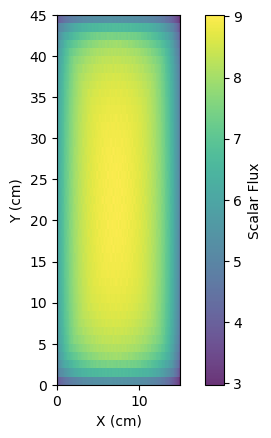

In [22]:

fig = plot_scalar_flux(solver)
for ext in ["pdf", "svg"]:
    fig.savefig(f"figures/01_sn_{material}.{ext}", bbox_inches="tight")

In [23]:
importlib.reload(SN)

mesh = SN.Mesh([total_dx], [sn_material(material)], dx)
angles, weights = np.polynomial.legendre.leggauss(8)
sn_solver = SN.DiscreteOrdinates(angles=angles, weights=weights, mesh=mesh, left_boundary=1, right_boundary=0)

sn_solver.angular_flux();

: Converged after 1 iterations


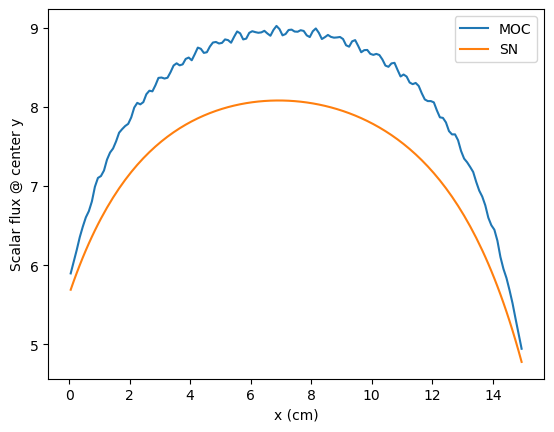

In [24]:
sn_x = sn_solver.mesh.get_cell_x_positions()
sn_flux = sn_solver.average_scalar_flux_at_cells

moc_pos, moc_flux = solver.extract_scalar_flux_on_line(0, total_dy/2, total_dx, total_dy/2)

fig, ax = plt.subplots()
ax.plot(moc_pos, moc_flux, label="MOC")
ax.plot(sn_x, sn_flux, label="SN")
ax.legend()
ax.set_xlabel("x (cm)")
ax.set_ylabel("Scalar flux @ center y")

for ext in ["pdf", "svg"]:
    fig.savefig(f"figures/01_sn_{material}_comparison.{ext}", bbox_inches="tight")